#Fungsi

In [ ]:
!pip install featuretools
# Basic libraries of python for numeric and dataframe computations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVC
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from sklearn.metrics import accuracy_score

import sklearn
import seaborn as sns

from numpy import asarray
from numpy import *
from numba import njit

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# Featauretools for feature engineering
import featuretools as ft



import statsmodels.formula.api as smf

#Importing our ML toolkit
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

# Importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings("ignore")
"""
%load_ext autoreload
%autoreload 2
"""


'\n%load_ext autoreload\n%autoreload 2\n'

In [ ]:
#Creating a function for comprehensive DEA, generic to any dataset
#______________________________________________________________________
#the input contains the dataset in data frame, and an optional column to drop, e.g. the target column
#i.e. the input parameter 'target' is optional

def discover(df, target=''):

    #Creating Seris with Feature Types, removing the target feature
    if target != '':
        df1 = df.drop(target, axis = 1, inplace = False)
    else:
        df1 = df

    #listing feature type
    feature_type = []
    for j in range(len(df1.columns)):
        if df1[df1.columns[j]].nunique()==2:
            feature_type.append('Binary')
        elif df1[df1.columns[j]].dtypes != 'O' and df1[df1.columns[j]].nunique()>10:
            feature_type.append('Numerical')
        elif df1[df1.columns[j]].dtypes != 'O' and df1[df1.columns[j]].nunique()<10:
            feature_type.append('Ordinal')
        elif df1[df1.columns[j]].nunique()<10:
            feature_type.append('Ordinal')
        else:
            feature_type.append('Identifier')

    #listing feature content
    features_content = []
    for i in range(len(df1.columns)):
        if df1[df1.columns[i]].nunique()<10:
            features_content.append(df1[df1.columns[i]].unique())
        else:
            features_content.append('n = ' + str(df1[df1.columns[i]].nunique()))

    #listing empty cells feature type
    num_of_empty = []
    for k in df1.columns:
        num_of_empty.append(df1[k].isnull().sum())

    #listing empty cells ratio feature type
    ratio_of_empty = []
    for k in df1.columns:
        ratio_of_empty.append(round(100*df1[k].isnull().sum()/df1[k].isnull().count(),2))

    discovered = pd.DataFrame({'Features': df1.columns,
                               'Features Content': features_content,
                               'Feature Type': feature_type,
                               'Empty Cells': num_of_empty,
                               '% Empty': ratio_of_empty
                             })
    discovered = discovered.sort_values(['Feature Type','Empty Cells'],ascending=False)
    print("Shape of Dataset: ",df.shape)
    return discovered
#_______________________________________________________________________________________________________________
#function to visualize the dataset, works with classification as well as regression data problems
#the function takes: df: the dataframe containing the dataset, and target: a string containing the column name of the target column to plot against
#_______________________________________________________________________________________________________________

def graph(df, target, spacing = 5):
    if target != '':
        df1 = df.drop(target, axis = 1, inplace = False)
    else:
        df1 = df

#listing feature types
    feature_type = []
    for j in range(len(df1.columns)):
        if df1[df1.columns[j]].nunique()==2:
            feature_type.append('Binary')
        elif df1[df1.columns[j]].dtypes != 'O' and df1[df1.columns[j]].nunique()>10:
            feature_type.append('Numerical')
        elif df1[df1.columns[j]].dtypes != 'O' and df1[df1.columns[j]].nunique()<10:
            feature_type.append('Ordinal')
        elif df1[df1.columns[j]].nunique()<10:
            feature_type.append('Ordinal')
        else:
            feature_type.append('Identifier')

    discovered = pd.DataFrame({'Features': df1.columns,
                                   'Feature Type': feature_type
                                 })

#_________________________________________________________________________________________________
# Plotting:
#_________________________________________________________________________________________________
    log_features = []
#plotting the target column
    plt.figure(figsize=(10,4))
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,  top=0.9, wspace=0.4, hspace=0.4)
    if df[target].nunique()<12:
        #classification/discrete target
        ax = df[target].value_counts().plot.barh()
        plt.title(f'{target} Count Plot')
    else:
        #continuous target
        sns.histplot(data=df, x = target)
        plt.title(f'{target} Count Plot')


#plotting ordinal & binary values:

    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,  top=0.9, wspace=0.4, hspace=0.4)
    plots = 0

    if df[target].nunique()<12:
        #classification/discrete target
        legends = df[target].unique()
        columns = min(spacing,len(discovered['Features'][discovered['Feature Type'] .isin(['Ordinal', 'Binary'])]))
        rows    = int(np.ceil(len(legends)*len(discovered['Features'][discovered['Feature Type'] .isin(['Ordinal', 'Binary'])])/spacing))
        plt.figure(figsize=(20,5*rows))
        for i in discovered['Features'][discovered['Feature Type'] .isin(['Ordinal', 'Binary'])]:
            plots = plots + 1
            plt.subplot(rows,columns,plots)
            sns.countplot(x=i, hue=target, data=df, palette="Set1")
            plt.title(f'{target} vs. {i}')
    else:
        #continuous target
        columns = min(spacing,len(discovered['Features'][discovered['Feature Type'] .isin(['Ordinal', 'Binary'])]))
        rows    = int(np.ceil(len(discovered['Features'][discovered['Feature Type'] .isin(['Ordinal', 'Binary'])])/spacing))
        plt.figure(figsize=(20,5*rows))
        for i in discovered['Features'][discovered['Feature Type'] .isin(['Ordinal', 'Binary'])]:
            plots = plots + 1
            plt.subplot(rows,columns,plots)
            sns.histplot(data=df, x = target, hue = i, kde = True, element = 'step')
            plt.title(f'{target} vs. {i}')

            if df.groupby(df[i]).size().skew(axis = 0, skipna = True)>2:
                plt.yscale('symlog')
                plt.ylim(0,max(df.groupby(df[i]).size()))
                log_features.append(i)

#plotting Numerical values:

    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,  top=0.9, wspace=0.4, hspace=0.4)
    columns = min(spacing,len(discovered['Features'][discovered['Feature Type'] =='Numerical']))
    rows    = int(np.ceil(len(discovered['Features'][discovered['Feature Type'] =='Numerical'])/spacing))
    plt.figure(figsize=(max(20,spacing*columns),5*rows))


    if df[target].nunique()<12:
        #classification/discrete target
        legends = df[target].unique()
        plots = 0
        for i in discovered['Features'][discovered['Feature Type'] =='Numerical']:
            plots = plots + 1
            plt.subplot(rows,columns,plots)
            sns.histplot(data = df, x = df[i], hue = target, hue_order = legends, kde = True, element = 'step')
            #plt.yscale('symlog')
            try:
                if df[i].skew(axis = 0, skipna = True)>2:
                    plt.xscale('symlog')
                    plt.xlim(0,max(df[i]))
                    log_features.append(i)
            except:
                continue
            plt.grid(visible=True, which='both', axis='both')
        plt.show()
    else:
        #continuous target
        plots = 0
        for i in discovered['Features'][discovered['Feature Type'] =='Numerical']:
            plots = plots + 1
            plt.subplot(rows,columns,plots)
            plt.grid(visible=True, which='both', axis='both')
            sns.scatterplot(data = df, x = i, y = target)
            try:
                if df[i].skew(axis = 0, skipna = True)>2:
                    plt.xscale('symlog')
                    plt.xlim(0,max(df[i]))
                    log_features.append(i)
            except:
                continue
            plt.grid(visible=True, which='both', axis='both')


#Plotting Overall Correlation Heatmap

    columns = min(spacing,len(discovered['Features'][discovered['Feature Type'] =='Numerical']))
    rows    = int(np.ceil(len(discovered['Features'][discovered['Feature Type'] =='Numerical'])/spacing))
    plt.figure(figsize=(5*columns,5*rows))
    cmap = sns.diverging_palette(230, 20, as_cmap = True)
    sns.heatmap(df.corr().abs(), annot = True, fmt = '.2f', cmap = cmap )
    plt.show()

    print(f'Finished plotting full dataset \n The following features were plotted on logarithmic scale:\n {log_features}')


def quick_transform(data): #encodes all non_numerical data to numerical, impute empty cells with zero
    from sklearn.preprocessing import OrdinalEncoder
    enc = OrdinalEncoder()
    datanew = data.fillna(data.mode().iloc[0])

    categ_data_filter = [datanew[j].dtypes == 'O' and datanew[j].nunique()<10 for j in datanew.columns]
    id_data_filter =    [datanew[j].dtypes == 'O' and datanew[j].nunique()>10 for j in datanew.columns]
    filtered_list = [datanew.columns[i] for i in range(len(categ_data_filter)) if categ_data_filter[i]]
    drop_list =     [datanew.columns[i] for i in range(len(id_data_filter)) if id_data_filter[i]]
    remain_list   = list(set(datanew.columns) - set( filtered_list))

    data_trans = []
    data_trans=enc.fit_transform(datanew[filtered_list])

    df = pd.DataFrame(columns=datanew[filtered_list].columns,data = data_trans)
    df[remain_list] = datanew[remain_list]
    df = df.drop(drop_list, axis=1)
    return df


def graph_PCA(data,target='', n='' ):
    from sklearn.decomposition import PCA
    if n != '':
        n
    else:
        n= int((data.shape[1])*0.5)

    #removing trivial columns: like ID, names, etc
    trivial_data_filter = [j!= target and data[j].nunique()>0.5*data.shape[0] for j in data.columns]
    filtered_list = [data.columns[i] for i in range(len(trivial_data_filter)) if trivial_data_filter[i]==False]
    data_copy = data[filtered_list]

    #Finding principal components for the data
    data_pca = pd.DataFrame(PCA(n_components=n, random_state=1).fit_transform(quick_transform(data_copy)))
    dataandpca = pd.concat([data_pca,data_copy], axis = 1)

    plt.figure(figsize=(20,8))
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,  top=0.9, wspace=0.4, hspace=0.4)

    if target != '':
        dataandpca[target] = data_copy[target]
        plt.title(f'{target} Projected on first two PCs')
        sns.scatterplot(dataandpca[0],dataandpca[1],data=dataandpca, hue= target)
        for i in data_copy.drop(target, axis=1).columns:
            if data_copy[i].nunique()<10:
                dataandpca[i]=data_copy[i]
                plt.figure(figsize=(20,8))
                sns.scatterplot(dataandpca[0],dataandpca[1],data=dataandpca, hue= i)
    else:
        for i in data_copy.columns:
            if data_copy[i].nunique()<10:
                dataandpca[i]=data_copy[i]
                plt.figure(figsize=(20,8))
                sns.scatterplot(dataandpca[0],dataandpca[1],data=dataandpca, hue= i)

#Import and Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import os

os.chdir("/content/drive/My Drive")


Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/kuliah/data_flood.csv')

In [ ]:
data.head()

,City,Month,Year,Rainfall,TempDay,WaterDist,SurfaceMoist,SubSurfaceMoist,Flood,Slope
0,Kota Jakarta Utara,1,2018,245.2028,7182.756,0.371973,259.2161,1180.725,1,1.700728
1,Kota Jakarta Barat,1,2018,230.7828,7180.833,0.378276,231.3344,1163.797,1,1.475896
2,Kota Jakarta Pusat,1,2018,262.3999,7180.894,0.191698,233.1815,1172.459,0,2.148673
3,Kota Jakarta Selatan,1,2018,255.9945,7175.891,0.157342,244.5133,1491.594,0,2.131970
4,Kota Jakarta Timur,1,2018,248.8404,7177.683,0.123802,259.6458,1531.485,0,1.883266


In [ ]:
data.describe()

,Month,Year,Rainfall,TempDay,WaterDist,SurfaceMoist,SubSurfaceMoist,Flood,Slope
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,6.500000,2019.000000,143.813108,7200.206989,0.779913,139.232182,763.975403,0.511111,1.868107
std,3.461682,0.818774,119.558171,14.265867,0.302441,91.109818,515.599384,0.501271,0.257784
min,1.000000,2018.000000,7.971299,7169.337000,0.000000,18.036130,86.247600,0.000000,1.475896
25%,3.750000,2018.000000,45.929600,7190.904500,0.591964,38.899865,193.987075,0.000000,1.700728
50%,6.500000,2019.000000,125.533200,7198.159500,0.913464,131.310500,741.224650,1.000000,1.883266
75%,9.250000,2020.000000,213.586050,7209.271000,1.000000,239.056550,1277.130750,1.000000,2.131970
max,12.000000,2020.000000,491.229600,7239.961000,1.140881,259.645800,1544.475000,1.000000,2.148673


In [ ]:
discover(data)

Shape of Dataset:  (180, 10)


,Features,Features Content,Feature Type,Empty Cells,% Empty
0,City,"[Kota Jakarta Utara, Kota Jakarta Barat, Kota ...",Ordinal,0,0.0
2,Year,"[2018, 2019, 2020]",Ordinal,0,0.0
9,Slope,"[1.700728, 1.475896, 2.148673, 2.13197, 1.883266]",Ordinal,0,0.0
1,Month,n = 12,Numerical,0,0.0
3,Rainfall,n = 180,Numerical,0,0.0
4,TempDay,n = 175,Numerical,0,0.0
5,WaterDist,n = 135,Numerical,0,0.0
6,SurfaceMoist,n = 180,Numerical,0,0.0
7,SubSurfaceMoist,n = 180,Numerical,0,0.0
8,Flood,"[1, 0]",Binary,0,0.0


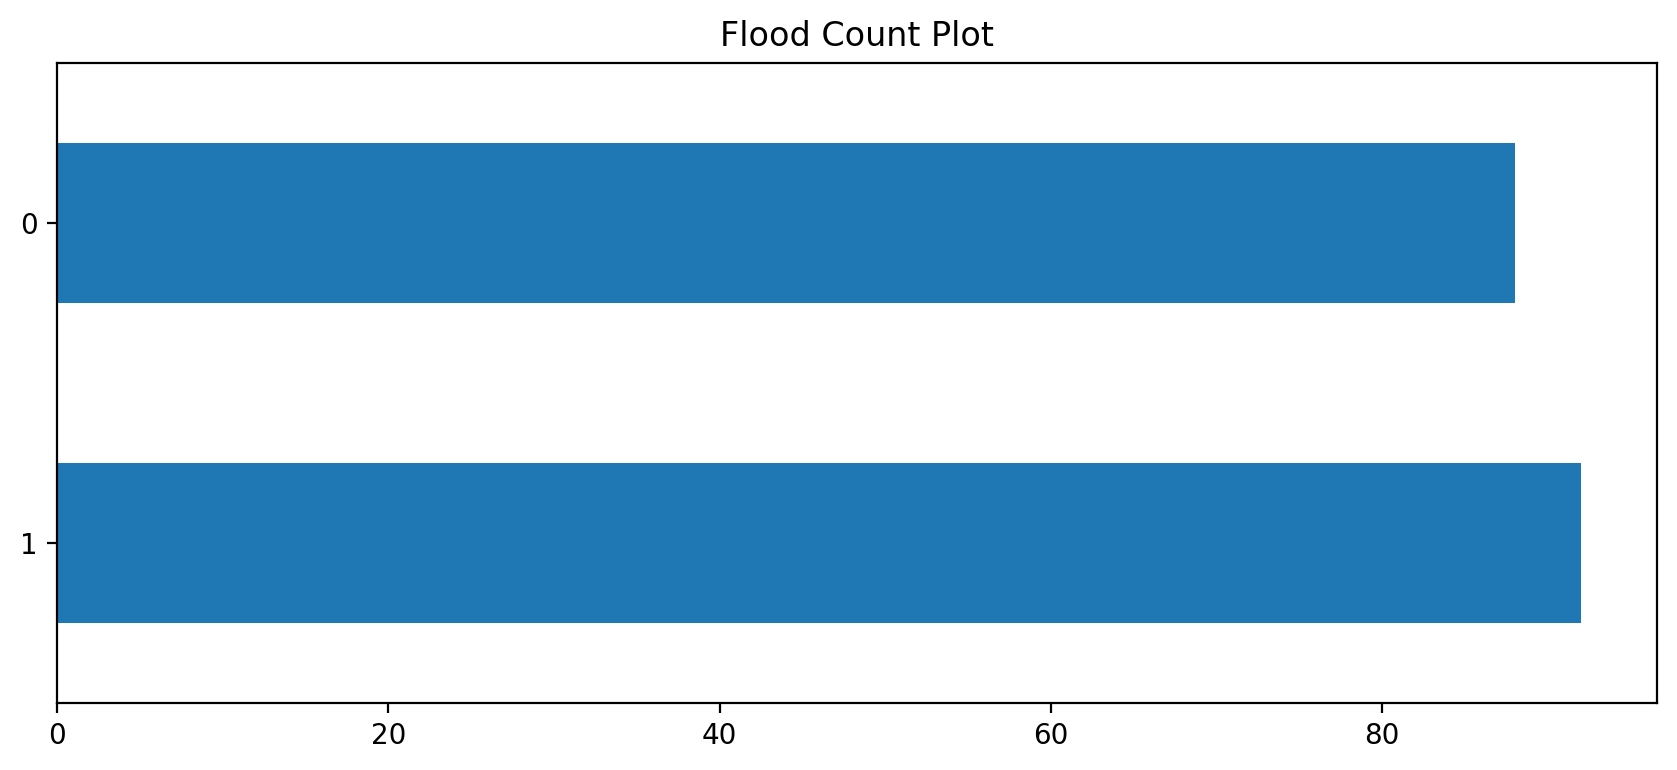

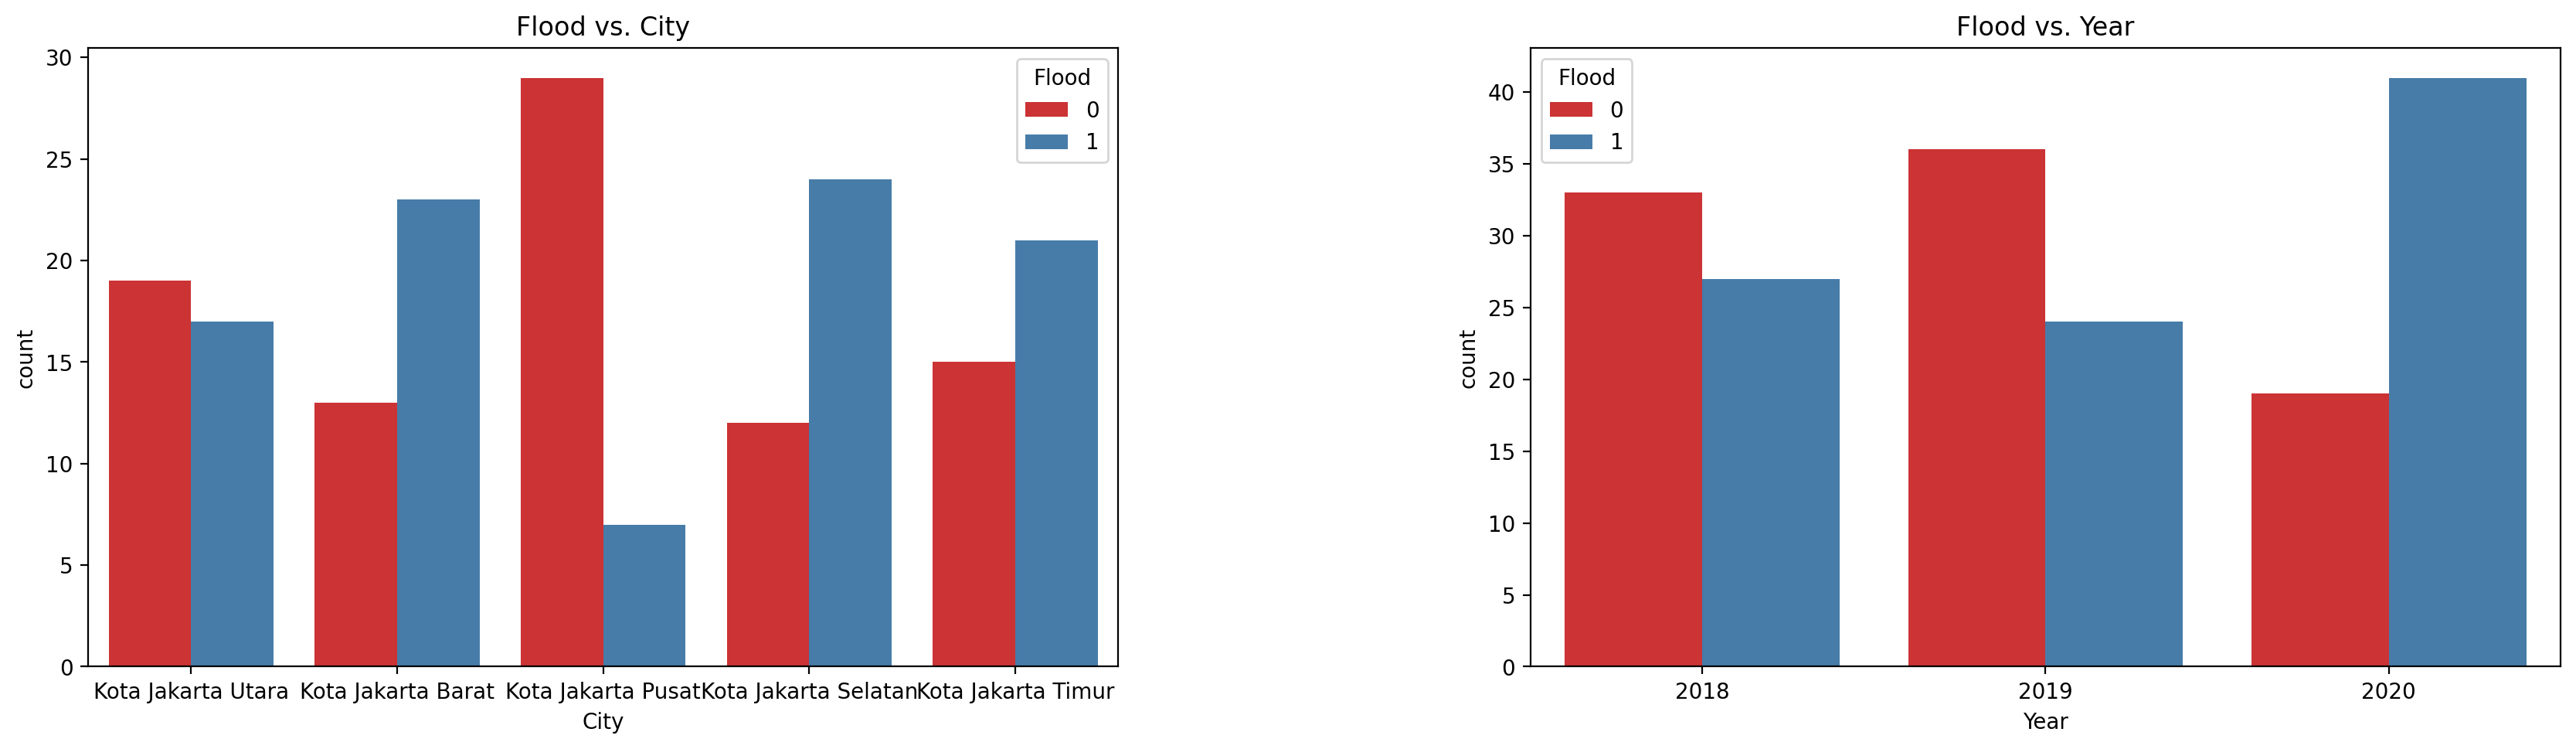

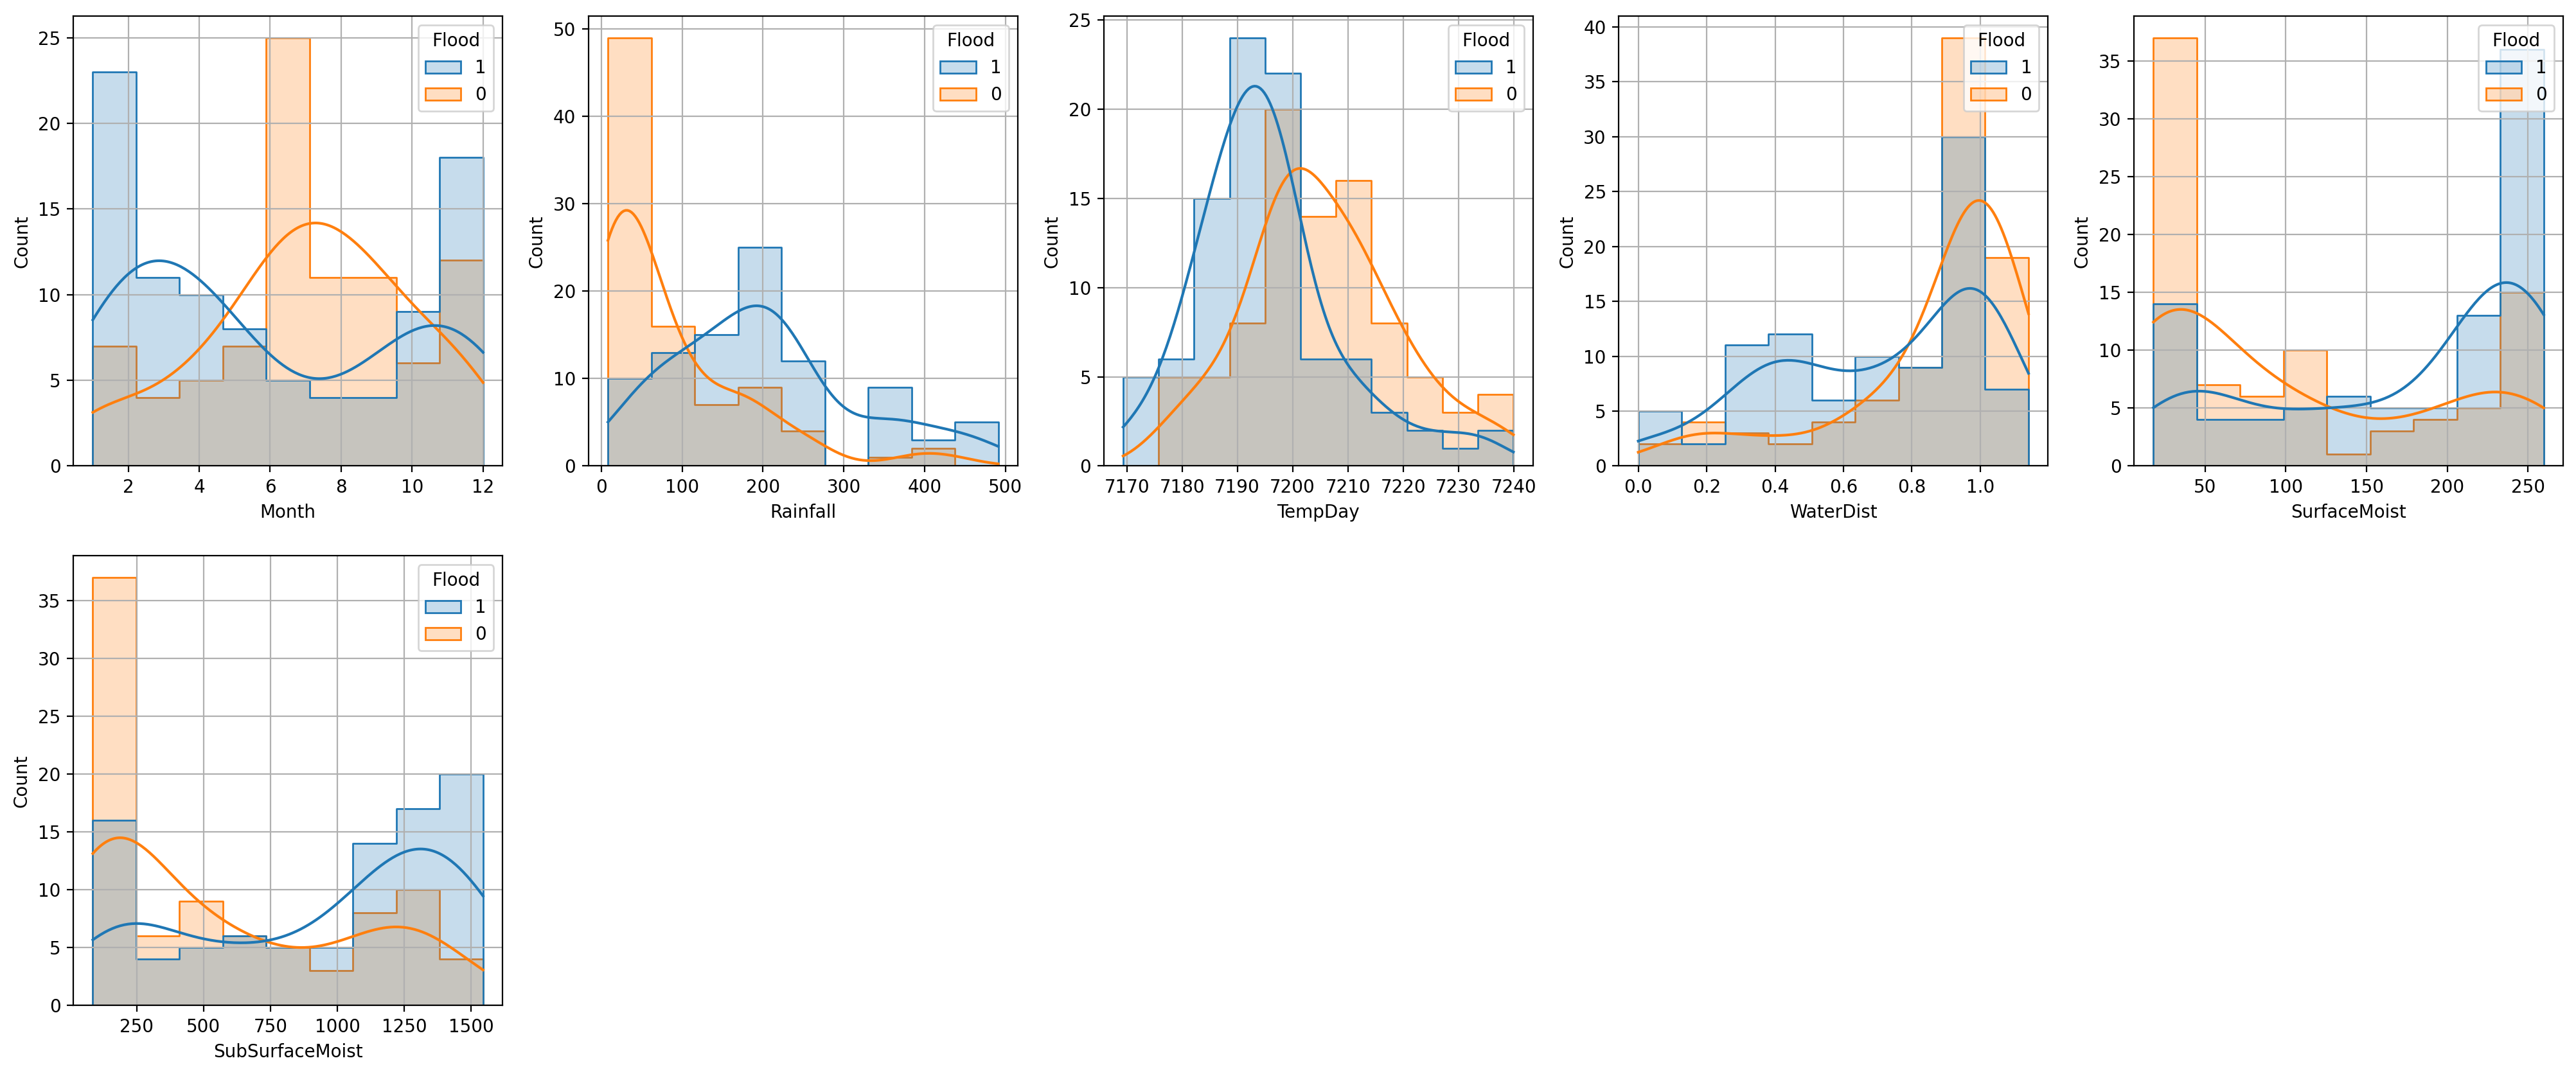

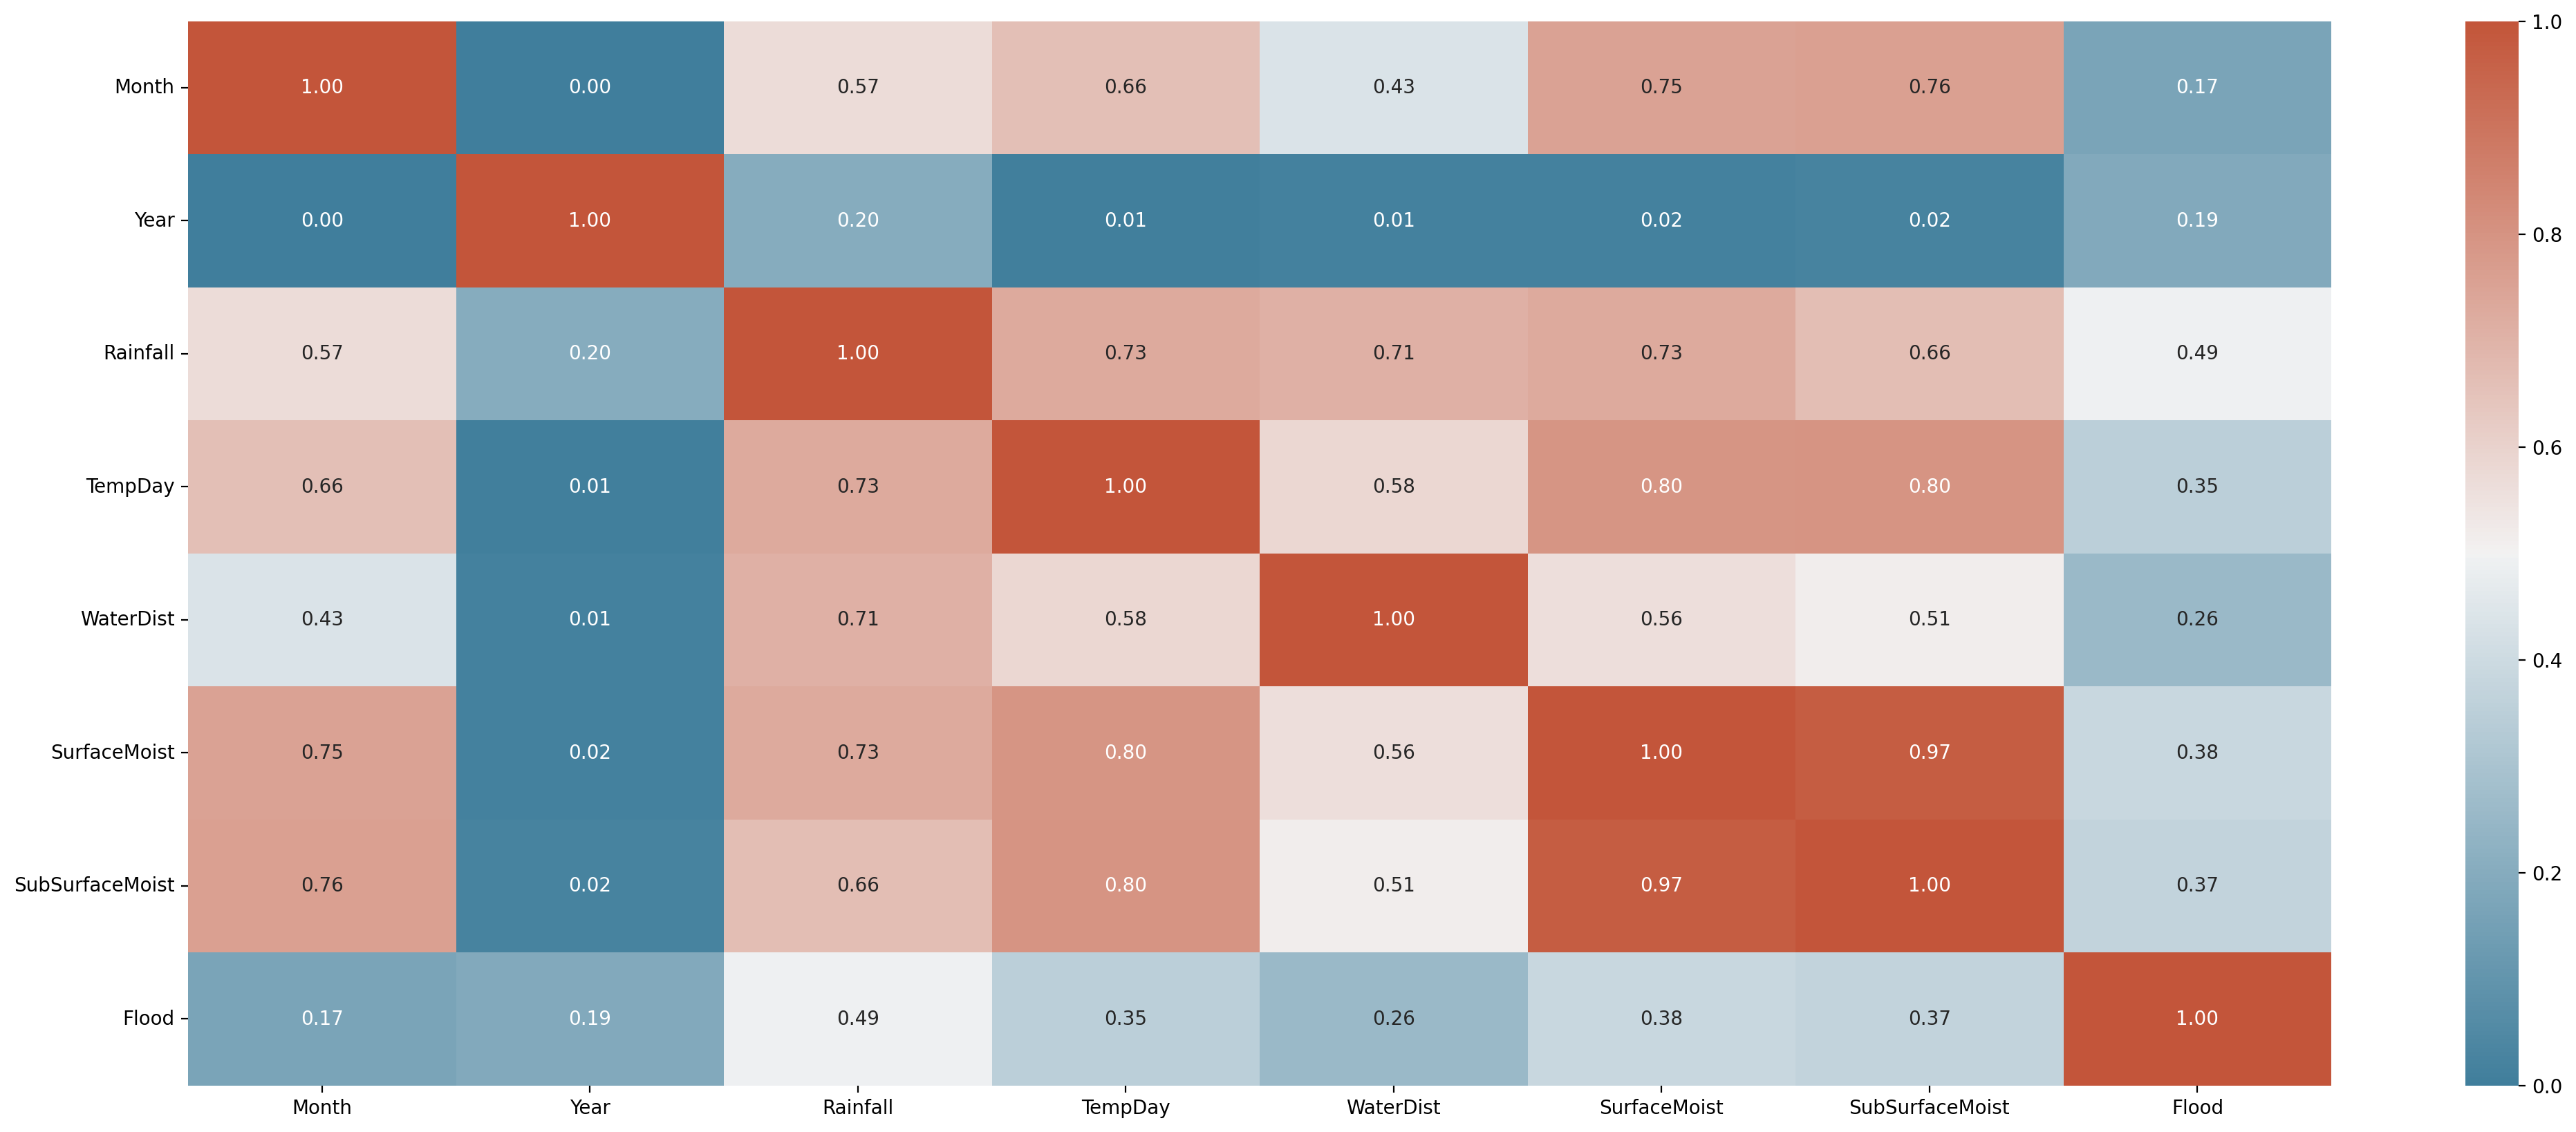

Finished plotting full dataset 
 The following features were plotted on logarithmic scale:
 []


In [ ]:
graph(data,'Flood')

In [ ]:
#Preprocessing
#Merubah data kategorikal menjadi binary
data=pd.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
data =  pd.DataFrame(sc_X.fit_transform(data.drop(["Flood"],axis = 1),),
        columns=['Month', 'Year', 'Rainfall', 'TempDay', 'WaterDist',
       'SurfaceMoist', 'SubSurfaceMoist','Slope','	City_Kota Jakarta Barat','	City_Kota Jakarta Pusat','	City_Kota Jakarta Timur','	City_Kota Jakarta Selatan','	City_Kota Jakarta Utara'])

In [ ]:
data.head()

,Month,Year,Rainfall,TempDay,WaterDist,SurfaceMoist,SubSurfaceMoist,Flood,Slope,City_Kota Jakarta Barat,City_Kota Jakarta Pusat,City_Kota Jakarta Selatan,City_Kota Jakarta Timur,City_Kota Jakarta Utara
0,1,2018,245.2028,7182.756,0.371973,259.2161,1180.725,1,1.700728,0,0,0,0,1
1,1,2018,230.7828,7180.833,0.378276,231.3344,1163.797,1,1.475896,1,0,0,0,0
2,1,2018,262.3999,7180.894,0.191698,233.1815,1172.459,0,2.148673,0,1,0,0,0
3,1,2018,255.9945,7175.891,0.157342,244.5133,1491.594,0,2.131970,0,0,1,0,0
4,1,2018,248.8404,7177.683,0.123802,259.6458,1531.485,0,1.883266,0,0,0,1,0


In [ ]:
data_x = data.drop(columns=['Flood'])
data_y = data[['Flood']]

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size=0.20, random_state = 42)

#Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, Y_train.values.ravel())
Y_pred = rfc.predict(X_test)
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(Y_test, Y_pred)))

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
print(classification_report(Y_test,Y_pred))
print('Confusion Matrix:',confusion_matrix(Y_test, Y_pred))

Model accuracy score with 10 decision-trees : 0.7500
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.75      0.86      0.80        21

    accuracy                           0.75        36
   macro avg       0.75      0.73      0.73        36
weighted avg       0.75      0.75      0.74        36

Confusion Matrix: [[ 9  6]
 [ 3 18]]


In [ ]:
from xgboost import XGBClassifier
import time

xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, Y_train.values.ravel())
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
# acc_xgb = (preds == Y_valid_change).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
# print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
# print("Time consumed for training: %4.3f" % (xgb_train_time))
# print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))
print('Model accuracy score with Best decision-trees : {0:0.4f}'. format(accuracy_score(Y_test, preds)))

Model accuracy score with Best decision-trees : 0.7778


In [ ]:
svc=SVC()

# fit classifier to training set
svc.fit(X_train,Y_train)
# make predictions on test set
y_pred=svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))

# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0)
# fit classifier to training set
linear_svc.fit(X_train,Y_train)
# make predictions on test set
y_pred_test=linear_svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(Y_test, y_pred_test)))

# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=100.0)
# fit classifier to training set
linear_svc.fit(X_train,Y_train)
# make predictions on test set
y_pred_test=linear_svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(Y_test, y_pred_test)))

# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1000.0)
# fit classifier to training set
linear_svc.fit(X_train,Y_train)
# make predictions on test set
y_pred_test=linear_svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(Y_test, y_pred_test)))

# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='poly', C=1.0)
# fit classifier to training set
linear_svc.fit(X_train,Y_train)
# make predictions on test set
y_pred_test=linear_svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with poly kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(Y_test, y_pred_test)))

# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='poly', C=100.0)
# fit classifier to training set
linear_svc.fit(X_train,Y_train)
# make predictions on test set
y_pred_test=linear_svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with poly kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(Y_test, y_pred_test)))

# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='poly', C=1000.0)
# fit classifier to training set
linear_svc.fit(X_train,Y_train)
# make predictions on test set
y_pred_test=linear_svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with poly kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(Y_test, y_pred_test)))

# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='sigmoid', C=1.0)
# fit classifier to training set
linear_svc.fit(X_train,Y_train)
# make predictions on test set
y_pred_test=linear_svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with poly sigmoid and C=1.0 : {0:0.4f}'. format(accuracy_score(Y_test, y_pred_test)))

# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='sigmoid', C=100.0)
# fit classifier to training set
linear_svc.fit(X_train,Y_train)
# make predictions on test set
y_pred_test=linear_svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with poly sigmoid and C=100.0 : {0:0.4f}'. format(accuracy_score(Y_test, y_pred_test)))

# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='sigmoid', C=1000.0)
# fit classifier to training set
linear_svc.fit(X_train,Y_train)
# make predictions on test set
y_pred_test=linear_svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with poly sigmoid and C=1000.0 : {0:0.4f}'. format(accuracy_score(Y_test, y_pred_test)))


Model accuracy score with default hyperparameters: 0.6389
Model accuracy score with linear kernel and C=1.0 : 0.7500
Model accuracy score with linear kernel and C=100.0 : 0.8056
Model accuracy score with linear kernel and C=1000.0 : 0.7500
Model accuracy score with poly kernel and C=1.0 : 0.7222
Model accuracy score with poly kernel and C=100.0 : 0.7500
Model accuracy score with poly kernel and C=1000.0 : 0.7500
Model accuracy score with poly sigmoid and C=1.0 : 0.4167
Model accuracy score with poly sigmoid and C=100.0 : 0.6944
Model accuracy score with poly sigmoid and C=1000.0 : 0.8056


In [ ]:
#Model for KNN

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(data.drop(["Flood"],axis = 1),),
        columns=['Month', 'Year', 'Rainfall', 'TempDay', 'WaterDist',
       'SurfaceMoist', 'SubSurfaceMoist','Slope','	City_Kota Jakarta Barat','	City_Kota Jakarta Pusat','	City_Kota Jakarta Timur','	City_Kota Jakarta Selatan','	City_Kota Jakarta Utara'])

y = data.Flood
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/5,random_state=42, stratify=y)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)

    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max train score 100.0 % and k = [1]
Max test score 83.33333333333334 % and k = [11, 13]


In [ ]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(13)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.8611111111111112